In [203]:
## imports
import pandas as pd
import ceseek as ce
import os
import torch
import tangermeme
from itertools import product
import math

gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu


device(type='cuda')

In [204]:
## load high activity library
high_activity_dev = pd.read_csv('Libraries/Dev_DeepSTARR_test_seq_library.csv')
high_activity_hk = pd.read_csv('Libraries/Hk_DeepSTARR_test_seq_library.csv')

high_activity_dev.head()

,sequence,actual_dev,pred_dev,se_dev
0,TGGCAAACGAACTCTCTCGAACAAAGATTGCGCTCCGCCAACCAAG...,7.045473,5.144914,3.612124
1,GACTTTTCATTCCATTGTTCTTGGTTCTCGGAAGTATCAACTTATT...,7.045473,5.113350,3.733098
2,GCGCTGCCCCATAAAACCATTGCTATTGCCGAAATTCCGGGAAGCC...,7.033815,5.447783,2.515496
3,TTCTTTTGTTAAACCGCTATCGCCGGAGGTTCATTGCTCTGTTCTG...,6.973096,5.044270,3.720369
4,AAACTAAAAACTTGTCGCGCCATAACTACGCCTCTCCAAAAAATGA...,6.973096,5.160999,3.283696


In [205]:
high_activity_dev.head()

,sequence,actual_dev,pred_dev,se_dev
0,TGGCAAACGAACTCTCTCGAACAAAGATTGCGCTCCGCCAACCAAG...,7.045473,5.144914,3.612124
1,GACTTTTCATTCCATTGTTCTTGGTTCTCGGAAGTATCAACTTATT...,7.045473,5.113350,3.733098
2,GCGCTGCCCCATAAAACCATTGCTATTGCCGAAATTCCGGGAAGCC...,7.033815,5.447783,2.515496
3,TTCTTTTGTTAAACCGCTATCGCCGGAGGTTCATTGCTCTGTTCTG...,6.973096,5.044270,3.720369
4,AAACTAAAAACTTGTCGCGCCATAACTACGCCTCTCCAAAAAATGA...,6.973096,5.160999,3.283696


In [206]:
# Make control sequences - for each sequence in the high activity library, make 1 10x dishuffled sequence with tangermeme
def csv_to_fasta(csv_file, fasta_file, sequence_col='sequence', id_cols=None):
    """
    Convert CSV with sequences to FASTA format
    
    Args:
        csv_file: path to input CSV
        fasta_file: path to output FASTA
        sequence_col: name of column containing sequences
        id_cols: list of columns to include in FASTA header (optional)
    """
    df = pd.read_csv(csv_file)
    
    with open(fasta_file, 'w') as f:
        for idx, row in df.iterrows():
            # Create header - use index if no id_cols specified
            if id_cols:
                header_parts = [f"{col}={row[col]}" for col in id_cols if col in df.columns]
                header = f">seq_{idx}_" + "_".join(header_parts)
            else:
                header = f">seq_{idx}"
            
            # Write FASTA entry
            f.write(f"{header}\n{row[sequence_col]}\n")
            

def make_control_sequences(df, output_file, n=10):
    from tangermeme.ersatz import dinucleotide_shuffle
    from tangermeme.utils import one_hot_encode
    from tangermeme.utils import characters
    import torch
    
    sequences = df['sequence'].tolist()
    
    with open(output_file, 'w') as f:
        for orig_idx, seq in enumerate(sequences):
            # Convert single sequence to one-hot: shape (4, seq_len)
            one_hot = one_hot_encode(seq)
            
            # Add batch dimension for dinucleotide_shuffle: shape (1, 4, seq_len)
            one_hot_batch = one_hot.unsqueeze(0)
            
            # Generate n shuffled versions: returns shape (1, 4*n, seq_len)
            shuffled_batch = dinucleotide_shuffle(one_hot_batch, n=n, random_state=None)
            
            # Remove batch dimension and reshape: (4*n, seq_len) -> (n, 4, seq_len)
            shuffled_no_batch = shuffled_batch.squeeze(0)  # (4*n, seq_len)
            shuffled_reshaped = shuffled_no_batch.view(n, 4, -1)  # (n, 4, seq_len)
            
            # Convert each shuffled sequence to string
            for shuffle_num in range(n):
                # Extract single shuffled sequence: shape (4, seq_len)
                shuffled_seq_tensor = shuffled_reshaped[shuffle_num]
                
                # Convert to string using characters function
                shuffled_seq_str = characters(shuffled_seq_tensor)
                
                # Write to file
                f.write(f">shuffle_{orig_idx}_{shuffle_num}\n{shuffled_seq_str}\n")

In [207]:
# Get target and control sequences in fasta format

if not os.path.exists('CEseek_data/high_activity_dev_with_scores.fasta'):
    # Include metadata in headers
    csv_to_fasta('Libraries/Dev_DeepSTARR_test_seq_library.csv', 'CEseek_data/high_activity_dev_with_scores.fasta', 
        id_cols=['actual_dev', 'pred_dev', 'se_dev'])
        
if not os.path.exists('CEseek_data/high_activity_hk_with_scores.fasta'):
    csv_to_fasta('Libraries/Hk_DeepSTARR_test_seq_library.csv', 'CEseek_data/high_activity_hk_with_scores.fasta', 
        id_cols=['actual_hk', 'pred_hk', 'se_hk'])

if not os.path.exists('CEseek_data/high_activity_dev_control.fasta'):
    make_control_sequences(high_activity_dev, output_file='CEseek_data/high_activity_dev_control.fasta', n=10)

if not os.path.exists('CEseek_data/high_activity_hk_control.fasta'):
    make_control_sequences(high_activity_hk, output_file='CEseek_data/high_activity_hk_control.fasta', n=10)


#load fasta and print head to confirm
fasta_file_dev = 'CEseek_data/high_activity_dev_with_scores.fasta'
fasta_file_hk = 'CEseek_data/high_activity_hk_with_scores.fasta'
fasta_file_dev_control = 'CEseek_data/high_activity_dev_control.fasta'
fasta_file_hk_control = 'CEseek_data/high_activity_hk_control.fasta'

seq_count_dev = sum(1 for line in open(fasta_file_dev) if line.startswith('>'))
seq_count_hk = sum(1 for line in open(fasta_file_hk) if line.startswith('>'))

print(f"Number of sequences in {fasta_file_dev}: {seq_count_dev}, {high_activity_dev.shape[0]}")
print(f"Number of sequences in {fasta_file_hk}: {seq_count_hk}, {high_activity_hk.shape[0]}")

print(f'Control sequences length: {len(open(fasta_file_dev_control).readlines()) / 2}')
print(f'Control sequences length: {len(open(fasta_file_hk_control).readlines()) / 2}')

with open(fasta_file_dev_control, 'r') as f:
    print("")
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())
with open(fasta_file_hk_control, 'r') as f:
    print("")
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())



Number of sequences in CEseek_data/high_activity_dev_with_scores.fasta: 4005, 4005
Number of sequences in CEseek_data/high_activity_hk_with_scores.fasta: 3003, 3003
Control sequences length: 40050.0
Control sequences length: 30030.0

>shuffle_0_0

TACAGGAGGCGCGAAGAAATGTAAATTTCAAGACGCACCTAAAGCCAAACCGTAACACATTGATGTACTGACGAAAAAAAAAATCGAACGACGTTGAGAAGAAATATATCAAATGAACACCGATAGAATCAGAAGTAAAGGCTGTCTGACATGTAATCTGCAAATCTAAAACAGATTTCGATCGCAATGGTATGGCTAAACCTCAACTCAGATCCGTCAAAATCGTTTAACAGCCATCATGATACAGTC

>shuffle_0_1

TCTTTCGATAGCATCAGTAAGAATAACAACCGTAAATCACCAAAGTCAACGAATATTCTGAATCGAAGAGCACAATGAGTTTCATGTGAGGGAACGAACTCAACGTGATAAGCGAGAAAAGGTGCGGAAATCAAATACTGCATAAAATCACATGCGACCAAGTTTATCGAACCGTGGTCTAAAACTGATTATATGAGAAACACAAGCCGAATAAAAATCTAACTCCAAAATATGCCGACACTGCAAGTC


>shuffle_0_0

TTCAAATGAATACATAAATCAGCGCAATTATTTTTATTATGGATGGAGGTAATAAATCCGAGATTGCGTTGGAACGTCGTGGGCTACAATCATCGGAGAGATGGTAATTTCATGATTGAGATTAGTCTTATTCGAAACCTGTAAGTCGAAATAATCAATTCGATTTAAAAAACTGATGTGCGGCTATTTGCATTACATATCTACGTATCTTTCACGTAACG

In [208]:
## Load CEseek motifs.pwm
pwm_file = 'CEseek_data/DeepSTARR_dm6_motifs.pwm'

obj_dev = ce.CEseek(pwm_file)
obj_hk = ce.CEseek(pwm_file)

obj_dev.dict_motif.keys(), obj_hk.dict_motif.keys()

(odict_keys(['Jra', 'GATAe', 'CTCF', 'Atf6', 'CrebA', 'Max', 'twi', 'Dref']),
 odict_keys(['Jra', 'GATAe', 'CTCF', 'Atf6', 'CrebA', 'Max', 'twi', 'Dref']))

In [209]:
# load fasta into CEseek

obj_dev.load_sequences(fasta_file_dev, fasta_input=True, out_seq_len=249, sequence_set='target')
obj_hk.load_sequences(fasta_file_hk, fasta_input=True, out_seq_len=249, sequence_set='target')
obj_dev.load_sequences(fasta_file_dev_control, fasta_input=True, out_seq_len=249, sequence_set='control')
obj_hk.load_sequences(fasta_file_hk_control, fasta_input=True, out_seq_len=249, sequence_set='control')

obj_dev.scan_motifs(num_threads=8)
obj_hk.scan_motifs(num_threads=8)

len(obj_dev.sequences_control)/len(obj_dev.sequences), len(obj_hk.sequences_control)/len(obj_hk.sequences)



(10.0, 10.0)

In [210]:
## Get tfmodisco working so we can confirm motifs
## Need tangermemes attribution methods on my student model
## Plot Control counts vs Target counts



In [211]:
# Run enrichment analysis with proper standardization - no double counting

def run_enrichment_analysis(obj):
    """Run enrichment analysis using standardized orientations without double-counting"""
    print("=== Running Enrichment Analysis (Fixed - No Double Counting) ===")
    
    motif_names = list(obj.dict_motif.keys())
    motif_pairs = list(product(motif_names, repeat=2))
    print(f"Analyzing {len(motif_pairs)} motif pairs...")
    
    # Track processed standardized configurations to avoid duplicates
    processed_configs = set()
    results = []
    total_target = len(obj.sequences)
    total_control = len(obj.sequences_control)

    for i, (motif1, motif2) in enumerate(motif_pairs):
        # Get all raw counts first
        target_counts = obj.count_CE_configuration_for_motif_pair(
            motif1, motif2, target_sequences=True, device='cpu'
        )
        control_counts = obj.count_CE_configuration_for_motif_pair(
            motif1, motif2, target_sequences=False, device='cpu'
        )

        for config_pair in target_counts.keys():
            for strand_pair in target_counts[config_pair].keys():
                for spacing, count_target in target_counts[config_pair][strand_pair].items():
                    
                    # Parse strand_pair tuple
                    strand1, strand2 = strand_pair
                    
                    # Get standardized configuration
                    preferred_ce_name, other_ce_name = obj.CE_name_standardization(
                        motif1, motif2, strand1, strand2
                    )
                    
                    # Use the preferred (standardized) configuration
                    std_motif1, std_motif2, std_strand1, std_strand2 = preferred_ce_name
                    std_ce_name = (std_motif1, std_motif2, std_strand1, std_strand2, spacing)
                    
                    # Skip if we've already processed this standardized config
                    if std_ce_name in processed_configs:
                        continue
                    
                    processed_configs.add(std_ce_name)
                    
                    # Now count using the standardized parameters directly
                    # This gets the actual count for the standardized orientation
                    std_target_counts = obj.count_CE_configuration_for_motif_pair(
                        std_motif1, std_motif2, target_sequences=True, device='cpu'
                    )
                    std_control_counts = obj.count_CE_configuration_for_motif_pair(
                        std_motif1, std_motif2, target_sequences=False, device='cpu'
                    )
                    
                    # Get count for the specific standardized strand combination
                    std_config_pair = (std_motif1, std_motif2)
                    std_strand_pair = (std_strand1, std_strand2)
                    
                    try:
                        actual_target_count = std_target_counts[std_config_pair][std_strand_pair][spacing]
                        actual_control_count = std_control_counts[std_config_pair][std_strand_pair][spacing]
                    except KeyError:
                        # Skip if this exact standardized config doesn't exist
                        continue
                    
                    # Calculate statistics using actual counts (not combined counts)
                    a = actual_target_count
                    A = total_target
                    b = actual_control_count
                    B = total_control

                    p_val = obj._fisher_exact_test_for_motif_hits(a, A, b, B)
                    log2_fc = math.log2(((a + 1e-9) / A) / ((b + 1e-9) / B))
                    
                    # Only store significant results with reasonable counts
                    if a > 0 and a > b:
                        results.append({
                            'motif1': std_motif1,
                            'motif2': std_motif2,
                            'config_pair': std_config_pair,
                            'strand_pair': std_strand_pair,
                            'spacing': spacing,
                            'ce_count_target': actual_target_count,  # Use actual count, not combined
                            'ce_count_control': actual_control_count,
                            'p_value': p_val,
                            'log2_fc': log2_fc,
                            'ce_name': std_ce_name
                        })

    print(f"Found {len(results)} standardized CE configurations (no double-counting)")
    return results

In [212]:
dev_results = run_enrichment_analysis(obj_dev)
hk_results = run_enrichment_analysis(obj_hk)

dev_results_df = pd.DataFrame(dev_results)
hk_results_df = pd.DataFrame(hk_results)



=== Running Enrichment Analysis (Fixed - No Double Counting) ===
Analyzing 64 motif pairs...
Found 199 standardized CE configurations (no double-counting)
=== Running Enrichment Analysis (Fixed - No Double Counting) ===
Analyzing 64 motif pairs...
Found 156 standardized CE configurations (no double-counting)


In [213]:
dev_results_df.sort_values('ce_count_target', ascending=False)

,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,ce_name
99,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,162,68,5.067241e-114,4.574315,"(Dref, GATAe, +, +, -5)"
181,Dref,Dref,"(Dref, Dref)","(-, +)",1,40,0,1.849792e-42,38.541209,"(Dref, Dref, -, +, 1)"
183,Dref,Dref,"(Dref, Dref)","(-, +)",4,32,0,4.230561e-34,38.219281,"(Dref, Dref, -, +, 4)"
185,Dref,Dref,"(Dref, Dref)","(-, +)",9,28,0,6.362799e-30,38.026636,"(Dref, Dref, -, +, 9)"
145,twi,twi,"(twi, twi)","(-, -)",1,28,6,4.949999e-24,5.544321,"(twi, twi, -, -, 1)"
...,...,...,...,...,...,...,...,...,...,...
30,Jra,twi,"(Jra, twi)","(+, -)",10,2,0,8.262587e-03,34.219281,"(Jra, twi, +, -, 10)"
28,Jra,twi,"(Jra, twi)","(+, +)",2,2,0,8.262587e-03,34.219281,"(Jra, twi, +, +, 2)"
27,Jra,twi,"(Jra, twi)","(+, +)",4,2,1,2.328615e-02,4.321928,"(Jra, twi, +, +, 4)"
34,Jra,twi,"(Jra, twi)","(-, -)",6,2,1,2.328615e-02,4.321928,"(Jra, twi, -, -, 6)"


In [214]:
hk_results_df.sort_values('ce_count_target', ascending=False).head(10)

,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,ce_name
73,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,354,49,3.293969e-316,6.174824,"(Dref, GATAe, +, +, -5)"
24,GATAe,GATAe,"(GATAe, GATAe)","(-, +)",-2,102,10,2.809103e-94,6.672425,"(GATAe, GATAe, -, +, -2)"
134,Dref,Dref,"(Dref, Dref)","(-, +)",-2,48,10,1.522689e-40,5.584963,"(Dref, Dref, -, +, -2)"
136,Dref,Dref,"(Dref, Dref)","(-, +)",1,48,0,7.311219e-51,38.804243,"(Dref, Dref, -, +, 1)"
130,Dref,Dref,"(Dref, Dref)","(+, -)",0,48,2,7.453265e-48,7.906891,"(Dref, Dref, +, -, 0)"
138,Dref,Dref,"(Dref, Dref)","(-, +)",4,44,0,1.131588e-46,38.678713,"(Dref, Dref, -, +, 4)"
149,Dref,Dref,"(Dref, Dref)","(-, -)",4,40,0,1.742810e-42,38.541209,"(Dref, Dref, -, -, 4)"
141,Dref,Dref,"(Dref, Dref)","(-, +)",9,40,0,1.742810e-42,38.541209,"(Dref, Dref, -, +, 9)"
114,Dref,Dref,"(Dref, Dref)","(+, +)",4,38,2,1.401964e-37,7.569856,"(Dref, Dref, +, +, 4)"
23,GATAe,GATAe,"(GATAe, GATAe)","(+, -)",-1,36,8,2.276047e-30,5.491853,"(GATAe, GATAe, +, -, -1)"


In [215]:

# Standardization is now handled in run_enrichment_analysis, so just assign results
print("=== Using CEseek Standardized Results ===")

# Results are already standardized from run_enrichment_analysis
dev_results_std = dev_results_df.copy()
hk_results_std = hk_results_df.copy()

# Add std_config_pair column for compatibility with downstream code
dev_results_std['std_config_pair'] = dev_results_std['config_pair']
hk_results_std['std_config_pair'] = hk_results_std['config_pair']

print(f"\nDEV unique config_pairs: {dev_results_std['config_pair'].nunique()}")
print(f"DEV unique std_config_pairs: {dev_results_std['std_config_pair'].nunique()}")

print(f"\nHK unique config_pairs: {hk_results_std['config_pair'].nunique()}")
print(f"HK unique std_config_pairs: {hk_results_std['std_config_pair'].nunique()}")

print(f"\nDEV total configurations: {len(dev_results_std)}")
print(f"HK total configurations: {len(hk_results_std)}")

print("\nStandardization complete - no duplicates from strand scanning!")


=== Using CEseek Standardized Results ===

DEV unique config_pairs: 25
DEV unique std_config_pairs: 25

HK unique config_pairs: 21
HK unique std_config_pairs: 21

DEV total configurations: 199
HK total configurations: 156

Standardization complete - no duplicates from strand scanning!


In [216]:
dev_results_std.sort_values('ce_count_target', ascending=False).head(10)

,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,ce_name,std_config_pair
99,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,162,68,5.067241e-114,4.574315,"(Dref, GATAe, +, +, -5)","(Dref, GATAe)"
181,Dref,Dref,"(Dref, Dref)","(-, +)",1,40,0,1.849792e-42,38.541209,"(Dref, Dref, -, +, 1)","(Dref, Dref)"
183,Dref,Dref,"(Dref, Dref)","(-, +)",4,32,0,4.230561e-34,38.219281,"(Dref, Dref, -, +, 4)","(Dref, Dref)"
185,Dref,Dref,"(Dref, Dref)","(-, +)",9,28,0,6.362799e-30,38.026636,"(Dref, Dref, -, +, 9)","(Dref, Dref)"
145,twi,twi,"(twi, twi)","(-, -)",1,28,6,4.949999e-24,5.544321,"(twi, twi, -, -, 1)","(twi, twi)"
132,twi,twi,"(twi, twi)","(+, +)",1,28,4,1.588411e-25,6.129283,"(twi, twi, +, +, 1)","(twi, twi)"
178,Dref,Dref,"(Dref, Dref)","(+, -)",0,26,0,7.792508e-28,37.919721,"(Dref, Dref, +, -, 0)","(Dref, Dref)"
193,Dref,Dref,"(Dref, Dref)","(-, -)",4,26,0,7.792508e-28,37.919721,"(Dref, Dref, -, -, 4)","(Dref, Dref)"
163,Dref,Dref,"(Dref, Dref)","(+, +)",4,26,2,2.455224e-25,7.022368,"(Dref, Dref, +, +, 4)","(Dref, Dref)"
167,Dref,Dref,"(Dref, Dref)","(+, +)",0,24,2,2.584239e-23,6.906891,"(Dref, Dref, +, +, 0)","(Dref, Dref)"


In [217]:
hk_results_std.sort_values('ce_count_target', ascending=False).head(10)


,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,ce_name,std_config_pair
73,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,354,49,3.293969e-316,6.174824,"(Dref, GATAe, +, +, -5)","(Dref, GATAe)"
24,GATAe,GATAe,"(GATAe, GATAe)","(-, +)",-2,102,10,2.809103e-94,6.672425,"(GATAe, GATAe, -, +, -2)","(GATAe, GATAe)"
134,Dref,Dref,"(Dref, Dref)","(-, +)",-2,48,10,1.522689e-40,5.584963,"(Dref, Dref, -, +, -2)","(Dref, Dref)"
136,Dref,Dref,"(Dref, Dref)","(-, +)",1,48,0,7.311219e-51,38.804243,"(Dref, Dref, -, +, 1)","(Dref, Dref)"
130,Dref,Dref,"(Dref, Dref)","(+, -)",0,48,2,7.453265e-48,7.906891,"(Dref, Dref, +, -, 0)","(Dref, Dref)"
138,Dref,Dref,"(Dref, Dref)","(-, +)",4,44,0,1.131588e-46,38.678713,"(Dref, Dref, -, +, 4)","(Dref, Dref)"
149,Dref,Dref,"(Dref, Dref)","(-, -)",4,40,0,1.742810e-42,38.541209,"(Dref, Dref, -, -, 4)","(Dref, Dref)"
141,Dref,Dref,"(Dref, Dref)","(-, +)",9,40,0,1.742810e-42,38.541209,"(Dref, Dref, -, +, 9)","(Dref, Dref)"
114,Dref,Dref,"(Dref, Dref)","(+, +)",4,38,2,1.401964e-37,7.569856,"(Dref, Dref, +, +, 4)","(Dref, Dref)"
23,GATAe,GATAe,"(GATAe, GATAe)","(+, -)",-1,36,8,2.276047e-30,5.491853,"(GATAe, GATAe, +, -, -1)","(GATAe, GATAe)"


In [218]:
# Quick plots for motif enrichment analysis
import matplotlib.pyplot as plt
import numpy as np

def plot_motif_enrichment(results_df):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Log2 Fold Change vs P-value (Volcano plot)
    ax1.scatter(results_df['log2_fc'], -np.log10(results_df['p_value']), alpha=0.6, s=50)   
    ax1.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Log2 Fold Change')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('Volcano Plot: Motif Enrichment')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Add labels for significant motifs
    significant = results_df[results_df['p_value'] < 0.05]
    for idx, row in significant.iterrows():
        if abs(row['log2_fc']) > 0.5:  # Only label if fold change > 1.4x
            ax1.annotate(row['config_pair'], (row['log2_fc'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    # Plot 2: Target vs Control counts
    ax2.scatter(results_df['ce_count_target'], results_df['ce_count_control'], alpha=0.6, s=50)
    # Add diagonal line for equal counts
    max_count = max(results_df['ce_count_target'].max(), results_df['ce_count_control'].max())
    ax2.plot([0, max_count], [0, max_count], 'r--', alpha=0.5, label='Equal counts')
    ax2.set_xlabel('Target Count')
    ax2.set_ylabel('Control Count')
    ax2.set_title('Target vs Control Motif Counts')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Add labels for interesting motifs
    for idx, row in results_df.iterrows():
        if row['p_value'] < 0.01 and abs(row['log2_fc']) > 1:  # Significant and high fold change
            ax2.annotate(row['config_pair'], (row['ce_count_target'], row['ce_count_control']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print some summary stats
    print(f"Total motifs analyzed: {len(results_df)}")
    print(f"Significant motifs (p<0.05): {sum(results_df['p_value'] < 0.05)}")
    print(f"Enriched in targets (log2_fc > 0): {sum(results_df['log2_fc'] > 0)}")
    print(f"Depleted in targets (log2_fc < 0): {sum(results_df['log2_fc'] < 0)}")
    print(f"High confidence (p<0.01, |log2_fc|>1): {sum((results_df['p_value'] < 0.01) & (abs(results_df['log2_fc']) > 1))}")


In [219]:
# Updated plotting function with configuration distribution
def plot_motif_enrichment_with_configs(results_df):
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Log2 Fold Change vs P-value (Volcano plot)
    ax1.scatter(results_df['log2_fc'], -np.log10(results_df['p_value']), alpha=0.6, s=50)
    ax1.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Log2 Fold Change')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('Volcano Plot: Motif Enrichment')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Target vs Control counts
    ax2.scatter(results_df['ce_count_target'], results_df['ce_count_control'], alpha=0.6, s=50)
    max_count = max(results_df['ce_count_target'].max(), results_df['ce_count_control'].max())
    ax2.plot([0, max_count], [0, max_count], 'r--', alpha=0.5, label='Equal counts')
    ax2.set_xlabel('Target Count')
    ax2.set_ylabel('Control Count')
    ax2.set_title('Target vs Control Motif Counts')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Plot 3: Configuration frequency distribution
    if 'num_configs' in results_df.columns:
        config_counts = results_df['num_configs'].value_counts().sort_index()
        ax3.bar(config_counts.index, config_counts.values, alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Number of Configurations')
        ax3.set_ylabel('Number of Motif Pairs')
        ax3.set_title('Motif Pair Configuration Distribution')
        ax3.grid(alpha=0.3, axis='y')
        
        # Add statistics
        mean_configs = results_df['num_configs'].mean()
        median_configs = results_df['num_configs'].median()
        ax3.axvline(mean_configs, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_configs:.1f}')
        ax3.axvline(median_configs, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_configs:.1f}')
        ax3.legend()
        
        # Set x-axis range
        max_possible = 64  # Adjust based on your data
        ax3.set_xlim(0, min(max_possible, results_df['num_configs'].max() + 5))
        
        print(f"Configuration stats:")
        print(f"  Mean configs per motif pair: {mean_configs:.1f}")
        print(f"  Median configs per motif pair: {median_configs:.1f}")
        print(f"  Max configs found: {results_df['num_configs'].max()}")
        print(f"  Motif pairs with max configs: {sum(results_df['num_configs'] == results_df['num_configs'].max())}")
    else:
        ax3.text(0.5, 0.5, 'Configuration data not found\nAdd "num_configs" column to results_df', 
                 transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        ax3.set_xlabel('Number of Configurations')
        ax3.set_ylabel('Number of Motif Pairs')
        ax3.set_title('Motif Pair Configuration Distribution')

    plt.tight_layout()
    plt.show()

    # Print summary stats
    print(f"Total motifs analyzed: {len(results_df)}")
    print(f"Significant motifs (p<0.05): {sum(results_df['p_value'] < 0.05)}")
    print(f"Enriched in targets (log2_fc > 0): {sum(results_df['log2_fc'] > 0)}")
    print(f"High confidence (p<0.01, |log2_fc|>1): {sum((results_df['p_value'] < 0.01) & (abs(results_df['log2_fc']) > 1))}")

# Use this function instead:
# plot_motif_enrichment_with_configs(your_results_df)


In [220]:
# Add confugration counts 
def add_config_counts(results_df, pair_col='std_config_pair', strand_col='strand_pair'):
    """
    Add a 'num_configs' column equal to the number of UNIQUE configuration
    combinations per motif pair, where a configuration is (strand, spacing).
    - strand values are normalized to one of {'++','+-','-+','--'} to avoid
      string-format duplicates.
    - pair_col should be a standardized pair label (e.g., 'std_config_pair').
    Prints a warning for any motif pair with >64 configs.
    """
    def norm_strand_pair(s):
        t = str(s).strip().strip('()').replace(' ', '').replace("'", "").replace('"', '')
        a, b = t.split(',')
        return a + b  # '++', '+-', '-+', '--'

    tmp = results_df.copy()
    tmp['strand_pair_norm'] = tmp[strand_col].apply(norm_strand_pair)

    # Count unique (strand, spacing) per motif pair
    unique_counts = (
        tmp.groupby(pair_col)
          .apply(lambda g: g[['strand_pair_norm', 'spacing']].drop_duplicates().shape[0])
    )

    # Warn if any CE exceeds 64
    over_limit = unique_counts[unique_counts > 64]
    if len(over_limit) > 0:
        for ce_pair, count in over_limit.items():
            print(f"WARNING: {ce_pair} has {count} unique configs (>64)")

    out = results_df.copy()
    out['num_configs'] = out[pair_col].map(unique_counts)

    # Report based on unique configuration counts
    print('Configuration statistics (normalized strands, unique spacing):')
    print(f"  Total rows (configuration rows): {len(out)}")
    print(f"  Unique motif pairs: {len(unique_counts)}")
    print(f"  Average configs per motif pair: {unique_counts.mean():.2f}")
    print(f"  Max configs for any motif pair: {unique_counts.max()}")
    print(f"  Motif pairs with only 1 config: {(unique_counts == 1).sum()}")
    print(f"  Motif pairs with >8 configs: {(unique_counts > 8).sum()}")

    return out


In [221]:
dev_results_std = add_config_counts(dev_results_std,'std_config_pair')
hk_results_std = add_config_counts(hk_results_std,'std_config_pair')

Configuration statistics (normalized strands, unique spacing):
  Total rows (configuration rows): 199
  Unique motif pairs: 25
  Average configs per motif pair: 7.96
  Max configs for any motif pair: 42
  Motif pairs with only 1 config: 3
  Motif pairs with >8 configs: 7
Configuration statistics (normalized strands, unique spacing):
  Total rows (configuration rows): 156
  Unique motif pairs: 21
  Average configs per motif pair: 7.43
  Max configs for any motif pair: 48
  Motif pairs with only 1 config: 5
  Motif pairs with >8 configs: 3


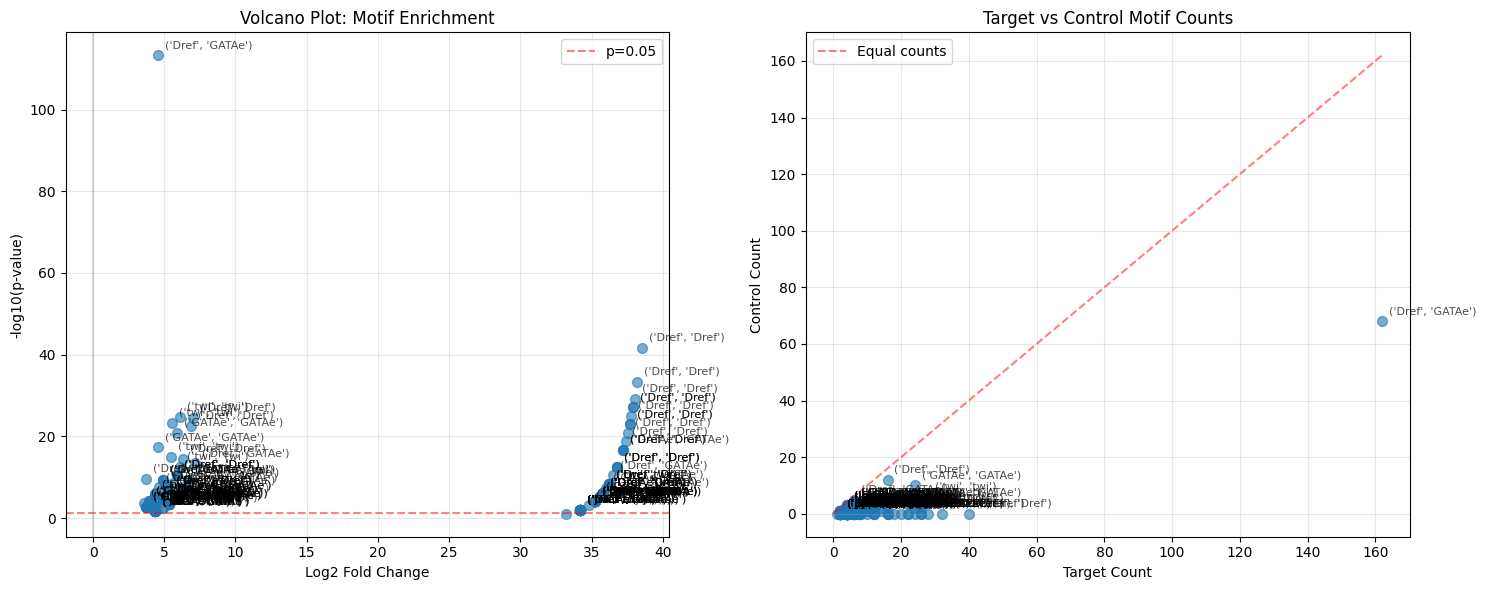

Total motifs analyzed: 199
Significant motifs (p<0.05): 198
Enriched in targets (log2_fc > 0): 199
Depleted in targets (log2_fc < 0): 0
High confidence (p<0.01, |log2_fc|>1): 181


In [222]:
plot_motif_enrichment(dev_results_std)

Configuration stats:
  Mean configs per motif pair: 18.3
  Median configs per motif pair: 15.0
  Max configs found: 42
  Motif pairs with max configs: 42


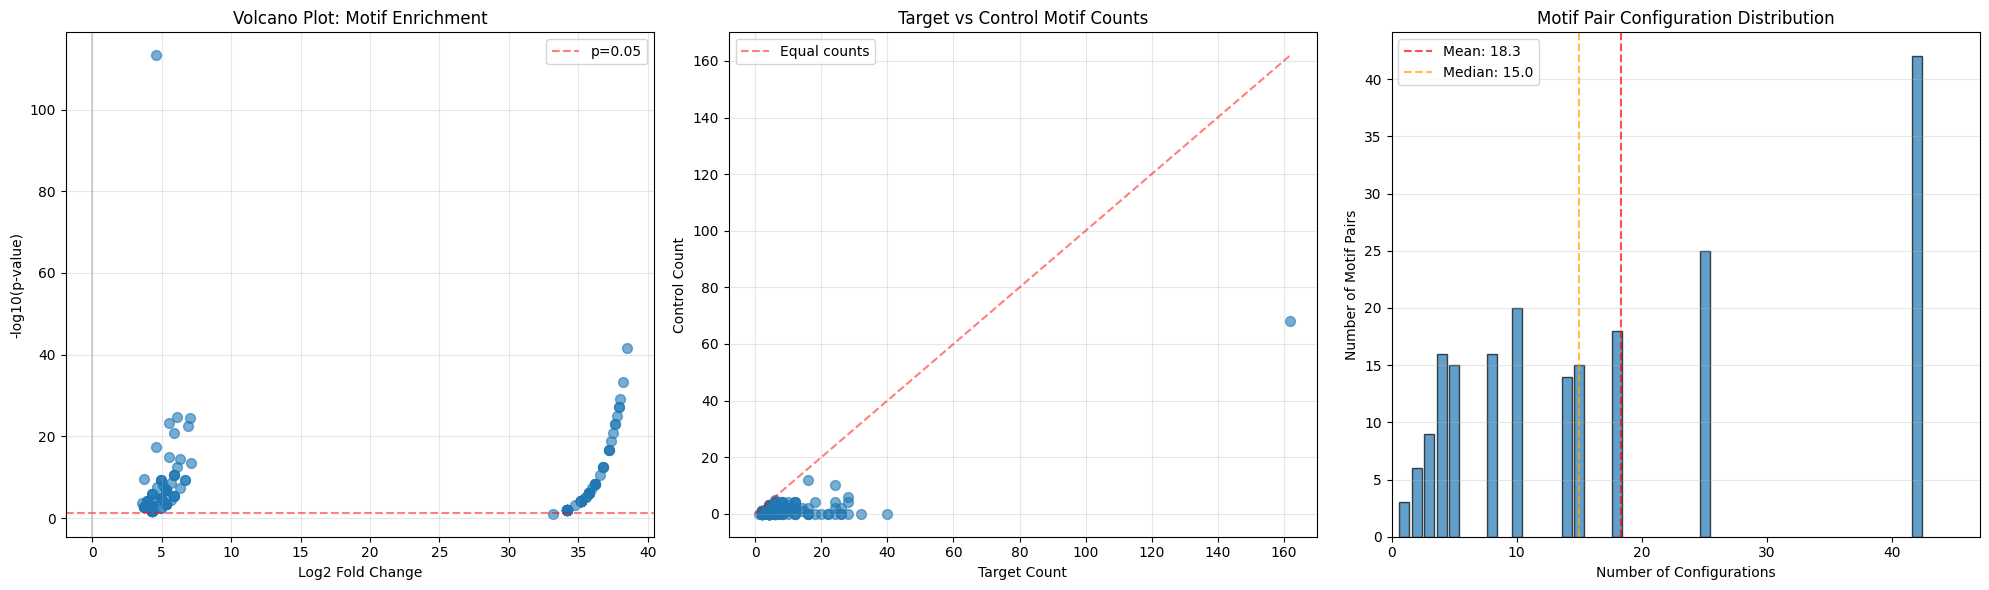

Total motifs analyzed: 199
Significant motifs (p<0.05): 198
Enriched in targets (log2_fc > 0): 199
High confidence (p<0.01, |log2_fc|>1): 181


In [223]:
plot_motif_enrichment_with_configs(dev_results_std)

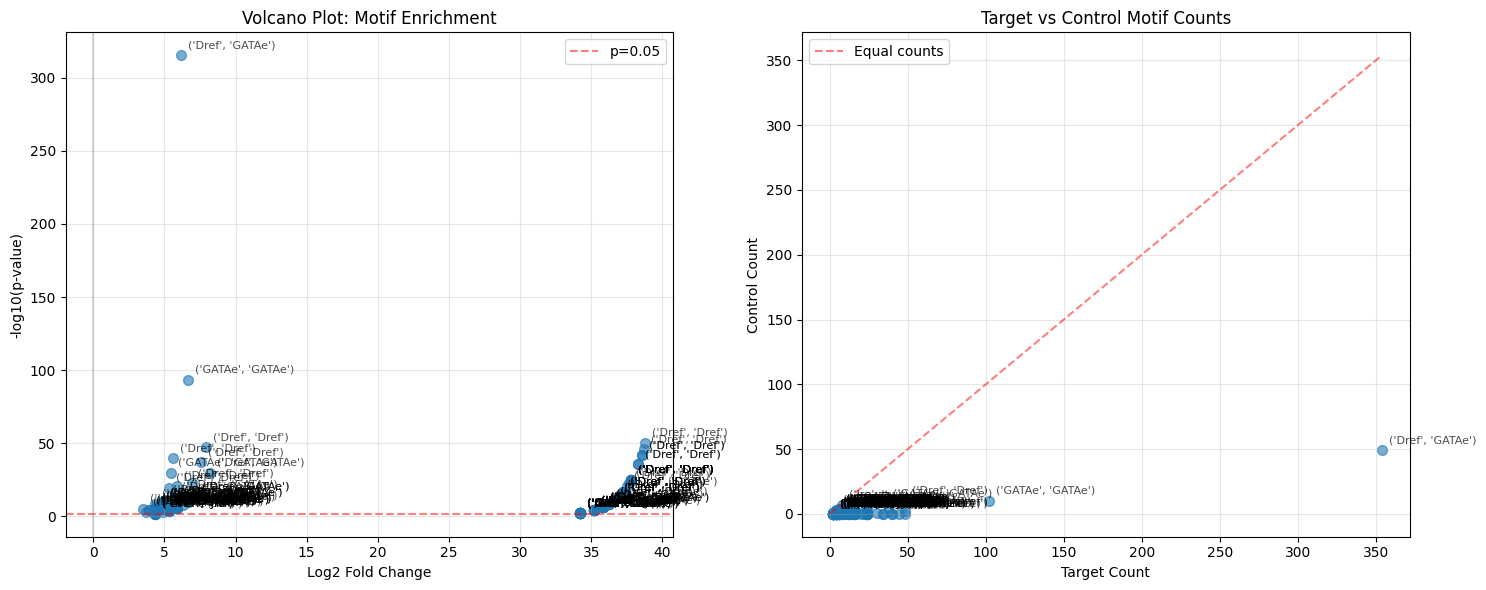

Total motifs analyzed: 156
Significant motifs (p<0.05): 156
Enriched in targets (log2_fc > 0): 156
Depleted in targets (log2_fc < 0): 0
High confidence (p<0.01, |log2_fc|>1): 151


In [224]:
plot_motif_enrichment(hk_results_std)

Configuration stats:
  Mean configs per motif pair: 25.8
  Median configs per motif pair: 35.0
  Max configs found: 48
  Motif pairs with max configs: 48


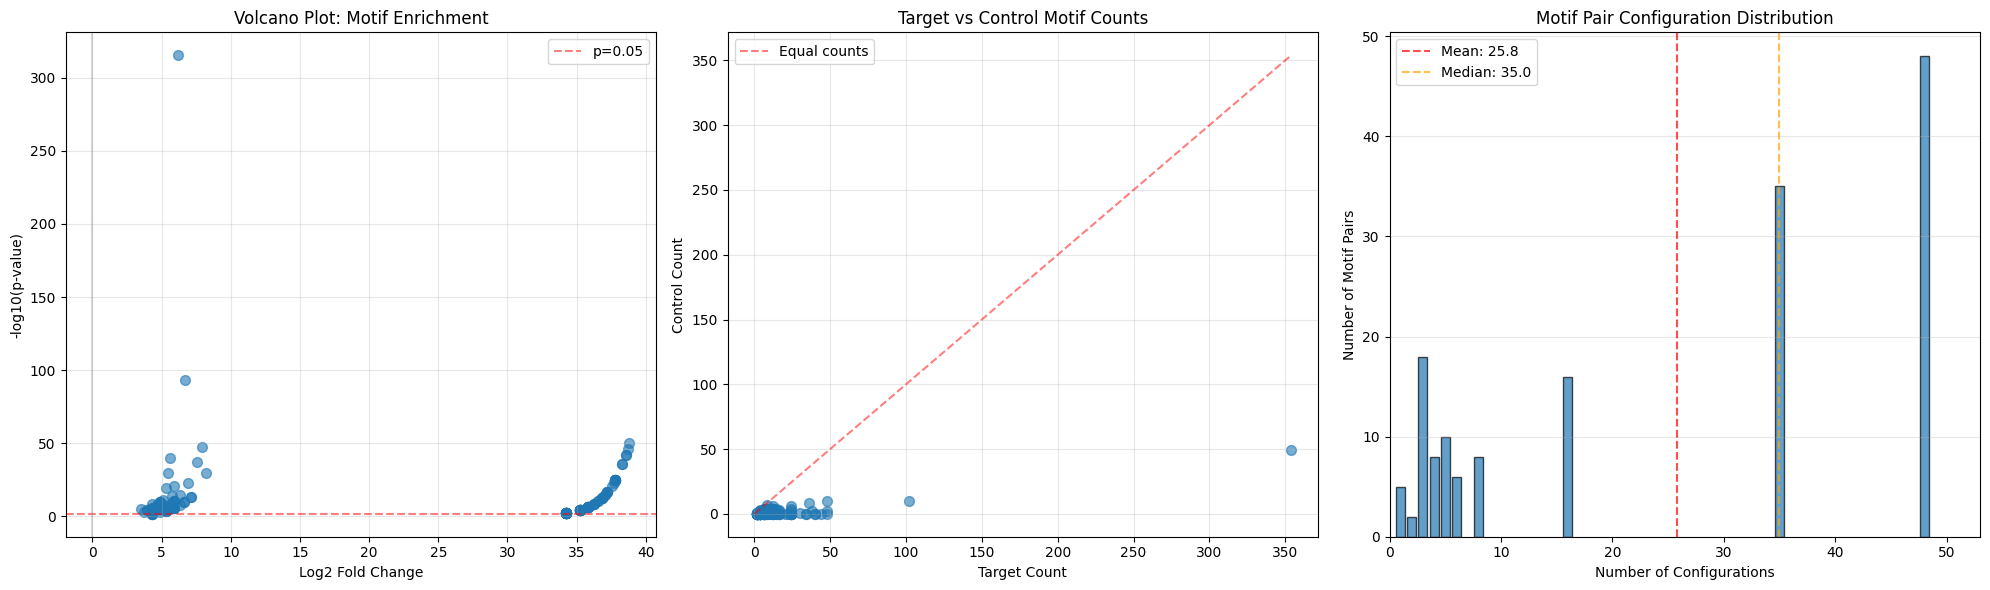

Total motifs analyzed: 156
Significant motifs (p<0.05): 156
Enriched in targets (log2_fc > 0): 156
High confidence (p<0.01, |log2_fc|>1): 151


In [225]:
plot_motif_enrichment_with_configs(hk_results_std)

In [226]:
sum(dev_results_std['ce_count_target'])

1544

In [227]:
4# First, let's check what the extract_sequences function does
print("CEseek extract_sequences function signature:")
import inspect
print(inspect.signature(obj_dev.extract_CE_sequences))
print("\nFunction docstring:")
print(obj_dev.extract_CE_sequences.__doc__)


CEseek extract_sequences function signature:
(motif_name1, motif_name2=None, strand1=None, strand2=None, spacing=None, outfile=None, device=None, return_pseudo_indices=False, chunk_size=2000, num_threads=1)

Function docstring:

        Extract composite element sequences.
        
        Args:
            motif_name1 (str): First motif name
            motif_name2 (str): Second motif name (optional)
            strand1 (str): First motif strand (optional)
            strand2 (str): Second motif strand (optional)
            spacing (int): Spacing between motifs (optional)
            outfile (str): Output file path (optional)
            device (str): Device to use ('cpu' or 'cuda')
            return_pseudo_indices (bool): Whether to return pseudo-indices
            chunk_size (int): Size of chunks for processing
            num_threads (int): Number of threads to use
            
        Returns:
            list or tuple: List of CE sequences, optionally with pseudo-indices
     

In [228]:
def extract_ce_to_dataframe(ceseek_obj, row):
    """
    Extract CE sequences from a DataFrame row using standardized orientations
    
    Args:
        ceseek_obj: CEseek object with loaded sequences
        row: DataFrame row with standardized motif1, motif2, strand_pair, spacing
    
    Returns:
        DataFrame with extracted sequences and metadata
    """
    motif1 = row['motif1']
    motif2 = row['motif2'] 
    strand1, strand2 = row['strand_pair']  # Already standardized from run_enrichment_analysis
    spacing = int(row['spacing'])
    ce_name = row['ce_name']
    
    # Use standardized strand orientations directly - no need to re-standardize
    ce_sequences, pseudo_indices, ce_sequences_ext = ceseek_obj.extract_CE_sequences(
        motif_name1=motif1, motif_name2=motif2,
        strand1=strand1, strand2=strand2, spacing=spacing,
        return_pseudo_indices=True, device='cuda', num_threads=8
    )
    
    n_sequences = len(ce_sequences)
    
    return pd.DataFrame({
        'ce_name': [ce_name] * n_sequences,
        'motif1': [motif1] * n_sequences,
        'motif2': [motif2] * n_sequences,
        'strand1': [strand1] * n_sequences,
        'strand2': [strand2] * n_sequences,
        'spacing': [spacing] * n_sequences,
        'log2_fc': [row['log2_fc']] * n_sequences,
        'p_value': [row['p_value']] * n_sequences,
        'pseudo_index': [idx for idx, orient in pseudo_indices],
        'orientation': [orient for idx, orient in pseudo_indices],
        'ce_sequence': ce_sequences,
        'endogenous_sequence': ce_sequences_ext
    })

def get_all_ce_sequences(ceseek_obj, results_df, dataset_name):
    """
    Extract sequences for all motif pairs and combine into single DataFrame
    
    Args:
        ceseek_obj: CEseek object (obj_dev or obj_hk)
        results_df: Results DataFrame (dev_results_std or hk_results_std)
        dataset_name: 'dev' or 'hk'
    
    Returns:
        Combined DataFrame with all sequences
    """
    all_dfs = []
    
    for idx, row in results_df.iterrows():
        try:
            ce_df = extract_ce_to_dataframe(ceseek_obj, row)
            ce_df['dataset'] = dataset_name
            all_dfs.append(ce_df)
            if idx % 50 == 0:
                print(f"Processed {idx+1}/{len(results_df)} motif pairs...")
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue
    
    return pd.concat(all_dfs, ignore_index=True)

# Extract sequences for both dev and hk
print(f"Extracting sequences for dev dataset, exprecting {sum(dev_results_std['ce_count_target'])} sequences")
dev_sequences_df = get_all_ce_sequences(obj_dev, dev_results_std, 'dev')

print(f"\nExtracting sequences for hk dataset, exprecting {sum(hk_results_std['ce_count_target'])} sequences")
hk_sequences_df = get_all_ce_sequences(obj_hk, hk_results_std, 'hk')

print(f"\nDev sequences: {len(dev_sequences_df)}")
print(f"Hk sequences: {len(hk_sequences_df)}")
print(f"\nDev dataset head:")
dev_sequences_df.head()


Extracting sequences for dev dataset, exprecting 1544 sequences
Processed 1/199 motif pairs...
Processed 51/199 motif pairs...
Processed 101/199 motif pairs...
Processed 151/199 motif pairs...

Extracting sequences for hk dataset, exprecting 2048 sequences
Processed 1/156 motif pairs...
Processed 51/156 motif pairs...
Processed 101/156 motif pairs...
Processed 151/156 motif pairs...

Dev sequences: 1543
Hk sequences: 2048

Dev dataset head:


,ce_name,motif1,motif2,strand1,strand2,spacing,log2_fc,p_value,pseudo_index,orientation,ce_sequence,endogenous_sequence,dataset
0,"(Jra, Jra, +, +, 6)",Jra,Jra,+,+,6,35.219281,0.000068,236672,+,TTGAATCATCACTCCGATTAGTCATC,AAGCACTTTGTATTACCATATCAAAATAAGGTTCAGCACTTAAAAC...,dev
1,"(Jra, Jra, +, +, 6)",Jra,Jra,+,+,6,35.219281,0.000068,282886,+,TTGAATCATCACTCCGATTAGTCATC,AACTTTGCTTTGAATGCAAACTTTGAATCATCACTCCGATTAGTCA...,dev
2,"(Jra, Jra, +, +, 6)",Jra,Jra,+,+,6,35.219281,0.000068,237149,+,GATGACTAATCGGAGTGATGATTCAA,AGGAGTGTGGCCTGTGTGTCATCATGTAGATTGTGTTGTTGTCAAA...,dev
3,"(Jra, Jra, +, +, 6)",Jra,Jra,+,+,6,35.219281,0.000068,282567,+,GATGACTAATCGGAGTGATGATTCAA,GTGGTTGTGGTGGAGCAACCCAGCTACAATCAGCCAGGACCCCCCC...,dev
4,"(Jra, Jra, +, +, 2)",Jra,Jra,+,+,2,35.219281,0.000068,1495095,+,ATGAGTCACTCACTTACTCATA,TCCGGTCGCATTCACCCACATATTGTGTTCATAATTTGTTTTCCCT...,dev


In [229]:
# Simple deduplication based on endogenous sequences (249bp sequences)
def deduplicate_endogenous_sequences(sequences_df, dataset_name):
    """Remove duplicates based on exact match or reverse complement of endogenous sequences"""
    
    def get_reverse_complement(seq):
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        return ''.join(complement.get(base, base) for base in seq[::-1])
    
    original_count = len(sequences_df)
    
    # Create canonical endogenous sequence (lexicographically smaller of seq and reverse complement)
    sequences_df = sequences_df.copy()
    sequences_df['endogenous_rc'] = sequences_df['endogenous_sequence'].apply(get_reverse_complement)
    sequences_df['canonical_endogenous'] = sequences_df.apply(
        lambda row: min(row['endogenous_sequence'], row['endogenous_rc']), axis=1
    )
    
    # Keep the sequence with lowest p-value for each canonical endogenous sequence
    deduplicated = (sequences_df
                   .sort_values(['canonical_endogenous', 'p_value'])
                   .drop_duplicates(subset=['canonical_endogenous'], keep='first')
                   .drop(columns=['endogenous_rc', 'canonical_endogenous']))
    
    removed = original_count - len(deduplicated)
    print(f"{dataset_name.upper()}: Removed {removed} endogenous sequence duplicates ({removed/original_count*100:.1f}%)")
    
    return deduplicated

# Apply deduplication to both datasets
dev_sequences_df = deduplicate_endogenous_sequences(dev_sequences_df, 'dev')
hk_sequences_df = deduplicate_endogenous_sequences(hk_sequences_df, 'hk')

print(f"\nFinal: DEV={len(dev_sequences_df)}, HK={len(hk_sequences_df)} unique sequences")

DEV: Removed 1241 endogenous sequence duplicates (80.4%)
HK: Removed 1712 endogenous sequence duplicates (83.6%)

Final: DEV=302, HK=336 unique sequences


In [243]:
dev_sequences_df.head(20)

,ce_name,motif1,motif2,strand1,strand2,spacing,log2_fc,p_value,pseudo_index,orientation,ce_sequence,endogenous_sequence,dataset
486,"(Dref, GATAe, +, +, 5)",Dref,GATAe,+,+,5,5.321928,3.162613e-04,1584661,+,TATCGATAGATTGCGATAAC,TTACTTTATACTTGAGATAGTAGTCTATCGATAGATTGCGATAACC...,dev
828,"(twi, twi, +, -, 6)",twi,twi,+,-,6,36.219281,4.635498e-09,846257,+,ACACATATATGTACATATGT,CAAGTGCCGCAGAAACATTTGCTGATAAAATGCAAGATTTCATAAT...,dev
540,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,620728,+,TATCGATAAG,ATTTAGCACGAGAAAACACAGATAATTGGCTATTCACAGCGACATA...,dev
534,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,433870,+,TATCGATAAG,AAAAATAGTTTTAAATAATTTTATTGAAATAGAAGTTTCAAAAAAT...,dev
541,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,639485,+,TATCGATAAC,AAAACGAAAACGTAGAGCTACCGTGCTTGGGTTCGATACTTGTGCT...,dev
543,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,710270,+,TATCGATAAG,AAAACATTTGATCAAAAACACAAATAAGAAAAATTTCCCACCATTT...,dev
517,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,139095,+,TATCGATAAC,AAAACGCAATATTCGTTTTTACATTCGCATTTGTTGCGAATAAATA...,dev
504,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,4.574315,5.067241e-114,18536,+,TATCGATAAG,GCGTAACTTTGAAAGACTTTCAGAAAAATATCAATTTTTGGTTTCC...,dev
94,"(GATAe, Jra, +, +, 4)",GATAe,Jra,+,+,4,6.643856,3.851699e-10,276895,+,AGATAAGCTAAGTGAATCATG,TGCCGTCAGATAAGCTAAGTGAATCATGCAATGAAGAGAGGCAATG...,dev
1191,"(Dref, Dref, +, -, 5)",Dref,Dref,+,-,5,5.906891,2.398414e-11,847311,+,TATCGATAGATTCAGTCGATA,GAGTTGCAGAGCTGCGAGGAATGATTAAAGCTGCAGGCCGCTTAGA...,dev


In [244]:
hk_sequences_df.head(20)

,ce_name,motif1,motif2,strand1,strand2,spacing,log2_fc,p_value,pseudo_index,orientation,ce_sequence,endogenous_sequence,dataset
528,"(Dref, GATAe, -, +, 5)",Dref,GATAe,-,+,5,35.804243,5.619148e-07,507985,+,TATCGATAGATTGCGATAAC,TTACTTTATACTTGAGATAGTAGTCTATCGATAGATTGCGATAACC...,hk
729,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,708160,+,TATCGATAAC,GAGCTATCGATAACACAAACAATTAAGGCTCCGAAATTAAATACCA...,hk
696,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,440950,+,TATCGATAAG,ATTTAGCACGAGAAAACACAGATAATTGGCTATTCACAGCGACATA...,hk
642,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,73816,+,TATCGATAAG,AAAAATAGTTTTAAATAATTTTATTGAAATAGAAGTTTCAAAAAAT...,hk
667,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,251543,+,TATCGATAAC,AAAACGAAAACGTAGAGCTACCGTGCTTGGGTTCGATACTTGTGCT...,hk
749,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,855188,+,TATCGATAAG,AAAACATTTGATCAAAAACACAAATAAGAAAAATTTCCCACCATTT...,hk
718,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,593737,+,TATCGATAAT,AAAACGAAGTAAAAGGACCTGATATATGTATACATTTATTATAAAT...,hk
641,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,49953,+,TATCGATAAC,AAAACGCAATATTCGTTTTTACATTCGCATTTGTTGCGAATAAATA...,hk
632,"(Dref, GATAe, +, +, -5)",Dref,GATAe,+,+,-5,6.174824,3.293969e-316,16046,+,TATCGATAAG,GCGTAACTTTGAAAGACTTTCAGAAAAATATCAATTTTTGGTTTCC...,hk
1886,"(Dref, Dref, -, -, 5)",Dref,Dref,-,-,5,36.804243,3.123190e-13,608769,+,TATCGATAGATTCAGTCGATA,GAGTTGCAGAGCTGCGAGGAATGATTAAAGCTGCAGGCCGCTTAGA...,hk


In [245]:
## Final save for dfs
dev_sequences_df.to_csv('Libraries/Dev_CEseek_sequences.csv', index=False)
hk_sequences_df.to_csv('Libraries/Hk_CEseek_sequences.csv', index=False)
